In [2]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import math
import numpy as np
import shutil
import os

# from accelerate import Accelerator, notebook_launcher

# Dataset

In [2]:
token_to_idx = {(i, j): i * 8 + j + 1 for i in range(8) for j in range(8)} | {"up": 65, "down": 66, "left": 67, "right": 68}

class SequenceDataset(Dataset):
    """A dataset class for handling sequence data."""
    def __init__(self, data, token_to_idx):
        self.data = data
        self.token_to_idx = token_to_idx
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X_sequence, Y_sequence = self.data[idx]
        X_indices = [self.token_to_idx[token] for token in X_sequence]
        Y_indices = [self.token_to_idx[token] for token in Y_sequence]
        return torch.tensor(X_indices, dtype=torch.long), torch.tensor(Y_indices, dtype=torch.long)

def collate_fn(batch):
    Xs, Ys = zip(*batch)
    Xs_padded = pad_sequence(Xs, batch_first=True, padding_value=0)
    Ys_padded = pad_sequence(Ys, batch_first=True, padding_value=0)
    return Xs_padded, Ys_padded

# Transformer Configuration

In [4]:
class Config:
    """Configuration class for GPT model parameters."""
    def __init__(self, vocab_size, block_size, n_embd, n_head, n_layer):
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_embd = n_embd
        self.n_head = n_head
        self.n_layer = n_layer
        self.embd_pdrop = 0.1
        self.resid_pdrop = 0.1
        self.attn_pdrop = 0.1

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        assert self.config.n_embd % self.config.n_head == 0, "Embedding dimension must be divisible by number of heads."
        
        # Key, query, and value projections
        self.key = nn.Linear(self.config.n_embd, self.config.n_embd)
        self.query = nn.Linear(self.config.n_embd, self.config.n_embd)
        self.value = nn.Linear(self.config.n_embd, self.config.n_embd)
        
        # Dropout layers
        self.attn_drop = nn.Dropout(self.config.attn_pdrop)
        self.resid_drop = nn.Dropout(self.config.resid_pdrop)
        
        # Output projection
        self.proj = nn.Linear(self.config.n_embd, self.config.n_embd)
        
        # Causal mask to prevent attention to future tokens
        self.register_buffer("mask", torch.tril(torch.ones((config.block_size, config.block_size))).unsqueeze(0).unsqueeze(1))

    def forward(self, x):
        B, T, C = x.size()
        # Calculate query, key, values for all heads and transpose
        k = self.key(x).view(B, T, self.config.n_head, C // self.config.n_head).transpose(1, 2)
        q = self.query(x).view(B, T, self.config.n_head, C // self.config.n_head).transpose(1, 2)
        v = self.value(x).view(B, T, self.config.n_head, C // self.config.n_head).transpose(1, 2)
        
        # Ensure mask is correctly broadcasted for the batch and heads
        mask = self.mask[:, :, :T, :T]
        
        # Scaled dot product attention with causality
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(C // self.config.n_head))
        att = att.masked_fill(mask == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = (att @ v).transpose(1, 2).reshape(B, T, C)
        
        # Apply dropout and projection
        y = self.resid_drop(self.proj(y))
        return y


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = CausalSelfAttention(config)
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )
        self.ln2 = nn.LayerNorm(config.n_embd)
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class TransformerModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Input embedding stem
        self.tok_emb = nn.Embedding(self.config.vocab_size, self.config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, self.config.block_size, self.config.n_embd))
        self.drop = nn.Dropout(self.config.embd_pdrop)
        
        # Transformer blocks
        self.blocks = nn.Sequential(*[TransformerBlock(self.config) for _ in range(self.config.n_layer)])
        
        # Decoder head
        self.ln_f = nn.LayerNorm(self.config.n_embd)
        self.head = nn.Linear(self.config.n_embd, self.config.vocab_size, bias=False)
        
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    
    def forward(self, idx, num_probe = None):
        _, T = idx.size()
        assert T <= self.config.block_size, "Input Sequence Too Long."
        
        token_embeddings = self.tok_emb(idx)
        position_embeddings = self.pos_emb[:, :T, :]
        x = self.drop(token_embeddings + position_embeddings)
        
        if num_probe == None:
            x = self.blocks(x)
        else:
            for block in self.blocks[:num_probe]:
                x = block(x)
            return x
                
        x = self.ln_f(x)
        logits = self.head(x)
        
        return logits

# Training and Inference

In [5]:
token_to_idx['<pad>'] = 0  # Padding token

vocab_size = 70   
block_size = 200
embed_size = 512
num_heads = 8
num_layers = 8
dropout = 0.1

In [6]:
path = 'total_filtered.pkl'
with open(path, 'rb') as file:
    processed = pickle.load(file)

In [7]:
d = len(processed)
train_ratio = 0.8
valid_ratio = 0.1

train = processed[:int(train_ratio * d)]
valid = processed[int(train_ratio * d):int((train_ratio + valid_ratio) * d) ]
test = processed[int((train_ratio + valid_ratio) * d): ]

In [8]:
train_dataset = SequenceDataset(train, token_to_idx)
valid_dataset = SequenceDataset(valid, token_to_idx)
test_dataset = SequenceDataset(test, token_to_idx)

In [9]:
print(len(train))

343303


In [10]:
def validate_model(model, valid_loader, accelerator):
    
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=0, reduction = 'none')

    valid_loss = torch.tensor(0.0).to(accelerator.device)
    valid_data = torch.tensor(0.0).to(accelerator.device)

    with torch.no_grad():

        for X_batch, Y_batch in valid_loader:

            logits = model(X_batch)
            logits = logits.view(-1, logits.size(-1))  # Shape: [batch_size * seq_length, vocab_size]
            Y_batch = Y_batch.view(-1)  # Shape: [batch_size * seq_length]

            # Assuming the padding token index is 0
            padding_token_index = 0
            mask = (Y_batch != padding_token_index).float()  # Create a mask for valid positions

            loss = criterion(logits, Y_batch)  # Calculate loss without reduction
            masked_loss = loss * mask  # Apply mask

            valid_loss += masked_loss.sum().item() # Sum the losses at valid positions
            valid_data += mask.sum().item() # Count valid positions

    accelerator.wait_for_everyone()
    valid_loss = accelerator.gather(valid_loss).sum()
    valid_data = accelerator.gather(valid_data).sum()

    if accelerator.is_main_process:
        return (valid_loss / valid_data).item()
    else:
        return None

In [11]:
def train_model(model, train_loader, optimizer, accelerator):

    model.train()
    criterion = nn.CrossEntropyLoss(ignore_index=0, reduction = 'none')

    train_loss = torch.tensor(0.0).to(accelerator.device)
    train_data = torch.tensor(0.0).to(accelerator.device)

    for X_batch, Y_batch in tqdm(train_loader, desc="Training"):
        
        optimizer.zero_grad()
        logits = model(X_batch)

        logits = logits.view(-1, logits.size(-1))  # Shape: [batch_size * seq_length, vocab_size]
        Y_batch = Y_batch.view(-1)  # Shape: [batch_size * seq_length]

        padding_token_index = 0  # Assuming the padding token index is 0
        mask = (Y_batch != padding_token_index).float()
        
        loss = criterion(logits, Y_batch)
        masked_loss = loss * mask
        
        loss_sum = masked_loss.sum()
        data_sum = mask.sum()

        loss = loss_sum / data_sum
        accelerator.backward(loss)
        optimizer.step()

        train_loss += loss_sum.item() 
        train_data += mask.sum().item()

    accelerator.wait_for_everyone()
    train_loss = accelerator.gather(train_loss).sum()
    train_data = accelerator.gather(train_data).sum()
    accelerator.print('Training Loss:', (train_loss / train_data).item())

In [12]:
def train_main(save_directory = None, epochs = 15):
    
    accelerator = Accelerator()

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

    config = Config(vocab_size, block_size, n_layer=num_layers, n_head=num_layers, n_embd=embed_size)
    model = TransformerModel(config)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)
    
    train_loader, valid_loader, model, scheduler, optimizer = accelerator.prepare(train_loader, valid_loader, model, scheduler, optimizer)

    epoch_loss = []
    epoch = 0

    model_path = None
    min_loss = 1e10
    
    for epoch in range(epochs):
        accelerator.print(f'Epoch {epoch}')

        train_model(model, train_loader, optimizer, accelerator)
        valid_loss = validate_model(model, valid_loader, accelerator)
        scheduler.step()

        if accelerator.is_main_process:
            print(f'Validation Loss: {valid_loss:.8f}')

            model_save_path = f"Model_{epoch+1}.pth"
            accelerator.save(accelerator.unwrap_model(model).state_dict(), model_save_path)

            if valid_loss < min_loss:
                min_loss = valid_loss
                model_path = model_save_path

        accelerator.wait_for_everyone()

    if accelerator.is_main_process:
        with open("Loss History.pkl", "wb") as f:
            pickle.dump(epoch_loss, f)
        shutil.copy(model_path, save_directory)


In [20]:
#notebook_launcher(train_main, ('best_model', 15), num_processes = 12)

NameError: name 'notebook_launcher' is not defined

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda")  
else:
    device = torch.device("cpu")

print("Device: ", device)

config = Config(vocab_size, block_size, n_layer=8, n_head=8, n_embd=512)
model = TransformerModel(config)

state_dict = torch.load('best_model', map_location=device)

model.load_state_dict(state_dict)
model.to(device)

Device:  cuda


TransformerModel(
  (tok_emb): Embedding(70, 512)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): TransformerBlock(
      (attn): CausalSelfAttention(
        (key): Linear(in_features=512, out_features=512, bias=True)
        (query): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (resid_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerBlock(
      (attn): CausalS

In [14]:
correct_predictions = 0
total_predictions = 0

padding_index = token_to_idx['<pad>']  # Assuming you have a token_to_idx mapping that includes '<pad>'
test_exact_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

model.eval()
with torch.no_grad():
    # Wrap data_loader with tqdm for a progress bar
    for X, Y_true in tqdm(test_exact_loader, desc="Evaluating", unit="batch"):
        X, Y_true = X.to(device), Y_true.to(device)
        logits = model(X)   

        for i in range(Y_true.shape[1]):  # Iterate over even indices
            logits_slice = logits[:, i, :]
            probabilities = F.softmax(logits_slice, dim=-1)
            Y_pred = torch.argmax(probabilities, dim=-1)

            # Identify non-padded positions in Y_true at position i
            non_padded_positions = Y_true[:, i] != padding_index

            # Update correct predictions considering only non-padded positions
            correct_predictions += ((Y_pred == Y_true[:, i]) & non_padded_positions).sum().item()
            # Update total predictions to exclude padded positions
            total_predictions += non_padded_positions.sum().item()

accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print(f"Accuracy: {accuracy}")


Evaluating: 100%|██████████| 1342/1342 [01:16<00:00, 17.45batch/s]

Accuracy: 0.7012092627192009


In [15]:
def return_idx(q_value_list, pos):
    # Returns Index of First Apperance of Position and Corresponding Q_Values At The Time
    for i in range(len(q_value_list)):
        if i % 2 == 0:
            if q_value_list[i][0] == pos:
                q_vals = [q_value_list[i][1].get(a) for a in ['up', 'down', 'left', 'right']]
                return i, q_vals
    return None, None

In [33]:
def generate_probe_training_data(position, test_dataset, q_value_annot, probe_layer):
    
    if torch.cuda.is_available():
        device = torch.device("cuda")  
    else:
        device = torch.device("cpu")

    config = Config(vocab_size, block_size, n_layer=8, n_head=8, n_embd=512)
    model = TransformerModel(config)

    state_dict = torch.load('best_model', map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

    embeddings = []
    q_values = []

    with torch.no_grad():
        for i, (X, Y) in enumerate(tqdm(test_dataset, desc='Processing')):
            
            idx, q_vals = return_idx(q_value_annot[i][0], position)
            
            if idx is not None and not all(q_val == 0 or q_val == 0.0 for q_val in q_vals):

                X_idx = [token_to_idx[token] for token in X]
                X_idx = torch.tensor(X_idx, dtype=torch.long).to(device)
                X_idx = X_idx.unsqueeze(0)
    
                embedding = model(X_idx, probe_layer)[:, idx, :]
                embeddings.append(embedding.cpu().T)
                q_values.append(q_vals)

    return embeddings, q_values 

In [18]:
# with open('q_values_filtered', 'rb') as f:
#     q_value = pickle.load(f)

with open('total_filtered_q_val', 'rb') as f:
    q_value = pickle.load(f)

In [19]:
q_value_train = q_value[:int(train_ratio * d)]

In [35]:
embeddings, q_values = generate_probe_training_data((6, 6), train, q_value_train, 4)
print(len(q_values))

Processing: 100%|██████████| 343303/343303 [08:19<00:00, 687.39it/s] 

174784


In [39]:
with open('embeddings', 'wb') as f:
    pickle.dump(embeddings, f)
with open('q_values', 'wb') as f:
    pickle.dump(q_values, f)

In [3]:
embeddings = []
q_values = []
with open('embeddings', 'rb') as f:
    embeddings = pickle.load(f)
with open('q_values', 'rb') as f:
    q_values = pickle.load(f)

In [44]:
print(embeddings[0])
print(embeddings[0].shape)
print(len(embeddings))

tensor([[-0.1713],
        [-2.3262],
        [ 0.2908],
        [-0.9448],
        [-0.0213],
        [ 1.0026],
        [ 1.8364],
        [-1.9883],
        [-1.0747],
        [-2.0777],
        [ 1.7525],
        [-0.8834],
        [-0.3668],
        [ 0.5636],
        [-1.6622],
        [ 2.2896],
        [-1.3314],
        [-3.0959],
        [ 3.1583],
        [ 1.0628],
        [-1.1916],
        [-1.2499],
        [ 0.8019],
        [-2.0620],
        [ 2.1856],
        [ 0.9100],
        [-0.5411],
        [ 0.9828],
        [ 1.7744],
        [-0.0059],
        [-1.2054],
        [-0.5721],
        [-3.0882],
        [-1.2745],
        [ 1.8910],
        [ 4.2283],
        [-0.6928],
        [-0.0955],
        [ 0.0892],
        [-0.2852],
        [-2.3206],
        [ 0.6072],
        [ 0.1490],
        [-4.0383],
        [ 0.0327],
        [ 0.6522],
        [ 1.6762],
        [-1.3287],
        [ 0.4788],
        [ 1.7877],
        [ 0.8405],
        [-0.2303],
        [ 1.

In [16]:
class Probe(nn.Module):
    
    def __init__(self, d, n):
        
        super(Probe, self).__init__()
        self.ln1 = nn.Linear(n, n)   
        self.act1 = nn.ReLU()
        self.ln2 = nn.Linear(n, d)   
        self.act2 = nn.ReLU()
        self.ln3 = nn.Linear(d, d)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.act1(self.ln1(x))
        x = self.act2(self.ln2(x))
        x = self.ln3(x)
        return x

    def predict(X, device):
    
        with torch.no_grad():
            
            X = X.to(device)
            
            pred = self.forward(X)
            
            return pred.cpu()

class ProbeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], torch.tensor(self.y[idx])

def train_probe(dataset, split, device, epochs, params, random):

    d, n = params

    min_loss = float('inf')
    best_epoch = 0
    
    criterion = nn.MSELoss()
    probe = Probe(d, n).to(device)
    
    optimizer = torch.optim.Adam(probe.parameters(), lr=0.0001, weight_decay = 1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.7)

    dataset_size = len(dataset)
    valid_size = int(dataset_size * split)
    train_size = dataset_size - valid_size
    
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

    model_save_dir = 'data/models'  # Adjust the path as needed
    os.makedirs(model_save_dir, exist_ok=True)  # Ensure the directory exists
    model_name = 'best_model'
    if random:
        model_name += '_random'
    model_name += '.pth'
    best_model_path = os.path.join(model_save_dir, model_name)  # Path to save the best model
    training_losses = []
    validation_losses = []
    
    for epoch in range(epochs):

        probe.train()

        train_loss = 0.0
        train_data = 0
        
        for X, y in train_loader:
            
            X, y = X.to(device), y.to(device)
            preds = probe(X)

            l1_lambda = 1e-5
            l1_norm = sum(p.abs().sum() for p in probe.parameters())
            loss = criterion(preds, y) + l1_lambda * l1_norm
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()
            train_data += X.shape[0]

        scheduler.step()
        valid_loss = validate(probe, valid_loader, device)

        if valid_loss < min_loss:
            min_loss = valid_loss
            best_epoch = epoch
            # Save the best model
            #torch.save(probe.state_dict(), best_model_path)
        training_losses.append(train_loss/train_data)
        validation_losses.append(valid_loss)
        print(f"Epoch {epoch+1}, Training Loss: {train_loss / train_data}, Validation Loss: {valid_loss}")

    print(f"Best Epoch: {best_epoch+1}, Minimum Validation Loss: {min_loss}")
    return training_losses, validation_losses

def validate(probe, valid_loader, device):

    #criterion = nn.MSELoss()
    #criterion = ranking_loss
    criterion = ranking_loss_binary
    probe.eval()

    with torch.no_grad():

        total_loss = 0.0
        total_data = 0

        for X, y in valid_loader:
    
            X, y = X.to(device), y.to(device)
            preds = probe(X)
    
            loss = criterion(preds, y)
            
            #total_loss += loss.item()
            total_loss += loss
            total_data += X.shape[0]

    return total_loss / total_data

def ranking_loss(preds, ground_truth):
    # Compute ranked positions of predictions and ground truth
    _, preds_ranked = preds.sort(descending=True)
    _, truth_ranked = ground_truth.sort(descending=True)

    # Compute the positions (ranks) of each element
    preds_positions = preds_ranked.argsort()
    truth_positions = truth_ranked.argsort()
    
    # Compute a loss between the positions
    loss = F.mse_loss(preds_positions.float(), truth_positions.float())
    return loss

def ranking_loss_binary(preds, ground_truth):
    # Compute ranked positions of predictions and ground truth
    _, preds_ranked = preds.sort(descending=True)
    _, truth_ranked = ground_truth.sort(descending=True)

    # Compute the positions (ranks) of each element
    preds_positions = preds_ranked.argsort()
    truth_positions = truth_ranked.argsort()
    
    # Compute a loss between the positions
    print(preds_positions)
    print(truth_positions)
    loss = 0 if torch.allclose(preds_positions, truth_positions, rtol=1e-05, atol=1e-08)  else 1
    return loss

In [5]:
def normalize_q_values(q_values):
    normalized = []
    d = len(q_values[0])
    for q in q_values:
        q_sum = sum(q)
        if q_sum == 0:
            new_list = [1] * d
            new_list = [item / d for item in new_list]
        else:
            new_list = [item / q_sum for item in q]
        normalized.append(new_list)
    return normalized

In [6]:
normalized_q_values = normalize_q_values(q_values)
random_tensors_list = [torch.randn(512, 1) for _ in range(174784)]
print(random_tensors_list[0].shape)

torch.Size([512, 1])


In [17]:
dataset = ProbeDataset(embeddings, normalized_q_values)
random_dataset = ProbeDataset(random_tensors_list, normalized_q_values)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d = len(q_values[0])
n = embeddings[0].shape[0]

print(d)
print(n)

training_losses, validation_losses = train_probe(dataset, split = 0.2, device = device, epochs = 200, params = (d, n), random = False)
training_losses_random, validation_losses_random = train_probe(random_dataset, split = 0.2, device = device, epochs = 200, params = (d, n), random = True)

4
512
Epoch 1, Training Loss: 0.001067433852542421, Validation Loss: 0.007838425449136056
Epoch 2, Training Loss: 0.0008263051634861198, Validation Loss: 0.007838425449136056
Epoch 3, Training Loss: 0.0007539732831897106, Validation Loss: 0.007838425449136056
Epoch 4, Training Loss: 0.0007150628311652751, Validation Loss: 0.007838425449136056
Epoch 5, Training Loss: 0.0006917307253144891, Validation Loss: 0.007838425449136056
Epoch 6, Training Loss: 0.0006759708981343877, Validation Loss: 0.007838425449136056
Epoch 7, Training Loss: 0.0006659202220966304, Validation Loss: 0.007838425449136056
Epoch 8, Training Loss: 0.0006559888874392019, Validation Loss: 0.007838425449136056
Epoch 9, Training Loss: 0.0006484248318057532, Validation Loss: 0.007838425449136056
Epoch 10, Training Loss: 0.0006441468198755962, Validation Loss: 0.007838425449136056
Epoch 11, Training Loss: 0.0006407702574366532, Validation Loss: 0.007838425449136056
Epoch 12, Training Loss: 0.0006375186941153903, Validation

In [9]:
with open('training_losses', 'wb') as f:
    pickle.dump(training_losses, f)
with open('training_losses_random', 'wb') as f:
    pickle.dump(training_losses_random, f)
with open('validation_losses', 'wb') as f:
    pickle.dump(validation_losses, f)
with open('validation_losses_random', 'wb') as f:
    pickle.dump(validation_losses_random, f)

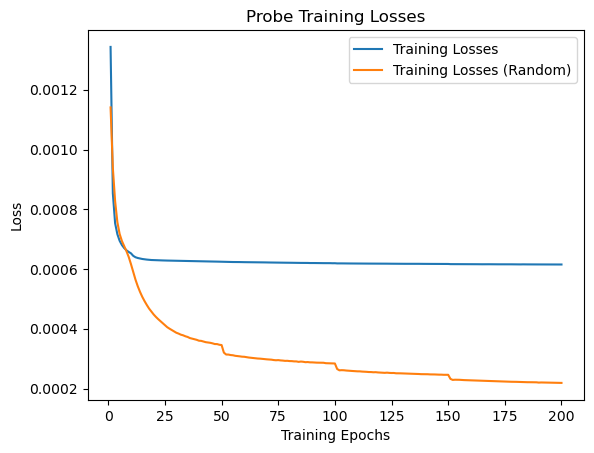

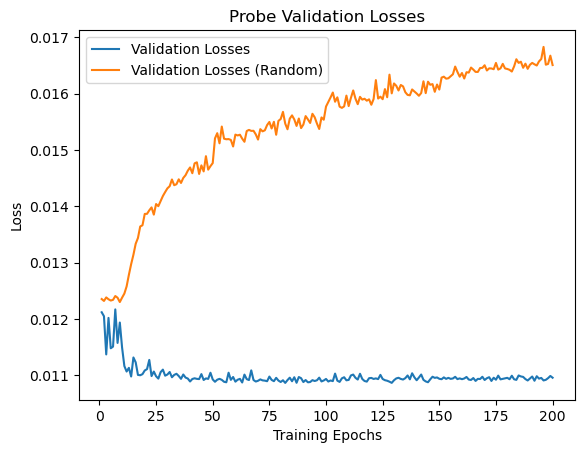

In [10]:
import matplotlib.pyplot as plt

# plt.figure()
# plt.plot(range(1, 201), training_losses, label='Training Losses')
# plt.plot(range(1, 201), training_losses_random, label='Training Losses (Random)')
# plt.title('Probe Training Losses')
# plt.xlabel('Training Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.savefig('training_losses.png')

# plt.figure()
# plt.plot(range(1, 201), validation_losses, label='Validation Losses')
# plt.plot(range(1, 201), validation_losses_random, label='Validation Losses (Random)')
# plt.title('Probe Validation Losses')
# plt.xlabel('Training Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.savefig('validation_losses.png')

plt.figure()
plt.plot(range(1, 201), training_losses, label='Training Losses')
plt.plot(range(1, 201), training_losses_random, label='Training Losses (Random)')
plt.title('Probe Training Losses (Binary)')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_losses_binary.png')

plt.figure()
plt.plot(range(1, 201), validation_losses, label='Validation Losses')
plt.plot(range(1, 201), validation_losses_random, label='Validation Losses (Random)')
plt.title('Probe Validation Losses (Binary)')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('validation_losses_binary.png')